# Baseline Results

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scikitplot as skplt
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score, roc_curve
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, Bidirectional
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

import sys
module_path = os.path.abspath(os.getcwd() + '\\..')
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.load_dataset import load_dataset, get_class_names, load_fusioned_dataset

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
    restore_best_weights=True,
)

In [7]:
epochs, batch_size = 25, 32
kf = KFold(n_splits=3, shuffle=True, random_state=48)

## 1. Unimodal Body Modality (Skeleton)

### Binary Classification

#### Dataset

In [6]:
X_train, X_test, y_train, y_test = load_dataset('skeleton', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(812, 1, 350, 35) (812, 1)
(245, 1, 350, 35) (245, 1)


In [7]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [123]:
class CNNLSTM():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='tanh'))(flatten)
        dense = Dense(64, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
8/8 - 5s - loss: 0.8454 - accuracy: 0.4979 - auc_58: 0.4858 - precision_53: 0.4902 - recall_53: 0.4202 - f1_score: 0.6611 - val_loss: 0.7077 - val_accuracy: 0.4463 - val_auc_58: 0.5618 - val_precision_53: 0.0000e+00 - val_recall_53: 0.0000e+00 - val_f1_score: 0.7059 - 5s/epoch - 596ms/step
Epoch 2/25
8/8 - 1s - loss: 0.7009 - accuracy: 0.4855 - auc_58: 0.4881 - precision_53: 0.4638 - recall_53: 0.2689 - f1_score: 0.6611 - val_loss: 0.6892 - val_accuracy: 0.5785 - val_auc_58: 0.5917 - val_precision_53: 0.6027 - val_recall_53: 0.6667 - val_f1_score: 0.7059 - 564ms/epoch - 71ms/step
Epoch 3/25
8/8 - 1s - loss: 0.6958 - accuracy: 0.5560 - auc_58: 0.5326 - precision_53: 0.5789 - recall_53: 0.3697 - f1_score: 0.6611 - val_loss: 0.6833 - val_accuracy: 0.5537 - val_auc_58: 0.5742 - val_precision_53: 0.5556 - val_recall_53: 0.9091 - val_f1_score: 0.7059 - 560ms/epoch - 70ms/step
Epoch 4/25
8/8 - 1s - loss: 0.6876 - accuracy: 0.5394 - auc_58: 0.5674 - precision_53: 0.5370 - recall_53:

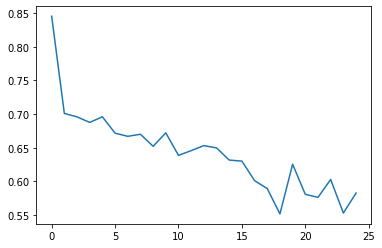

Epoch 1/25
8/8 - 4s - loss: 0.9299 - accuracy: 0.4896 - auc_59: 0.5005 - precision_54: 0.5048 - recall_54: 0.8400 - f1_score: 0.6831 - val_loss: 0.6963 - val_accuracy: 0.4959 - val_auc_59: 0.4847 - val_precision_54: 0.4959 - val_recall_54: 1.0000 - val_f1_score: 0.6630 - 4s/epoch - 489ms/step
Epoch 2/25
8/8 - 1s - loss: 0.6893 - accuracy: 0.5353 - auc_59: 0.5637 - precision_54: 0.5294 - recall_54: 0.9360 - f1_score: 0.6831 - val_loss: 0.6934 - val_accuracy: 0.5537 - val_auc_59: 0.5385 - val_precision_54: 0.5300 - val_recall_54: 0.8833 - val_f1_score: 0.6630 - 550ms/epoch - 69ms/step
Epoch 3/25
8/8 - 1s - loss: 0.6905 - accuracy: 0.5228 - auc_59: 0.5321 - precision_54: 0.5284 - recall_54: 0.7440 - f1_score: 0.6831 - val_loss: 0.6961 - val_accuracy: 0.4959 - val_auc_59: 0.5725 - val_precision_54: 0.4959 - val_recall_54: 1.0000 - val_f1_score: 0.6630 - 541ms/epoch - 68ms/step
Epoch 4/25
8/8 - 1s - loss: 0.6769 - accuracy: 0.5643 - auc_59: 0.6148 - precision_54: 0.5526 - recall_54: 0.8400 

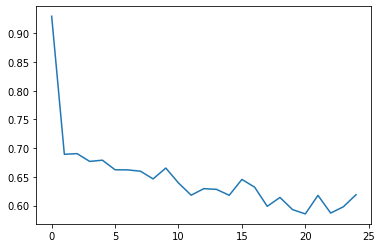

Epoch 1/25
8/8 - 5s - loss: 0.7694 - accuracy: 0.4876 - auc_60: 0.5056 - precision_55: 0.5065 - recall_55: 0.6190 - f1_score: 0.6848 - val_loss: 0.7173 - val_accuracy: 0.4917 - val_auc_60: 0.5729 - val_precision_55: 0.4917 - val_recall_55: 1.0000 - val_f1_score: 0.6592 - 5s/epoch - 568ms/step
Epoch 2/25
8/8 - 1s - loss: 0.6888 - accuracy: 0.5455 - auc_60: 0.5643 - precision_55: 0.5513 - recall_55: 0.6825 - f1_score: 0.6848 - val_loss: 0.6931 - val_accuracy: 0.4917 - val_auc_60: 0.5831 - val_precision_55: 0.4884 - val_recall_55: 0.7119 - val_f1_score: 0.6592 - 550ms/epoch - 69ms/step
Epoch 3/25
8/8 - 1s - loss: 0.6743 - accuracy: 0.5909 - auc_60: 0.6103 - precision_55: 0.5828 - recall_55: 0.7540 - f1_score: 0.6848 - val_loss: 0.6789 - val_accuracy: 0.5750 - val_auc_60: 0.6123 - val_precision_55: 0.6111 - val_recall_55: 0.3729 - val_f1_score: 0.6592 - 548ms/epoch - 69ms/step
Epoch 4/25
8/8 - 1s - loss: 0.6552 - accuracy: 0.6405 - auc_60: 0.6590 - precision_55: 0.6639 - recall_55: 0.6270 

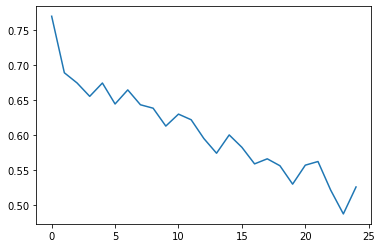

In [124]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs, binary=True)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [125]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 69.80% 
ROC/AUC: 0.68 
Precision: 0.91 
Recall: 0.71 
F1 score: 0.91


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

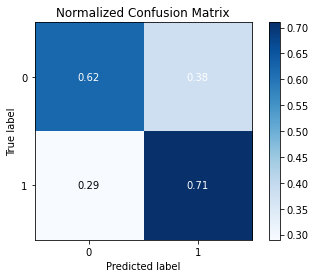

In [126]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10,8))

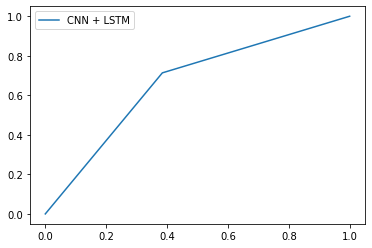

In [127]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [38]:
class RCNN():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 0.8772 - accuracy: 0.5749 - auc_18: 0.6203 - precision_18: 0.6024 - recall_18: 0.5426 - f1_score: 0.6853 - val_loss: 11.1983 - val_accuracy: 0.4686 - val_auc_18: 0.5000 - val_precision_18: 0.4686 - val_recall_18: 1.0000 - val_f1_score: 0.6382 - 2s/epoch - 105ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6821 - accuracy: 0.6858 - auc_18: 0.7193 - precision_18: 0.6867 - recall_18: 0.7305 - f1_score: 0.6853 - val_loss: 1.8675 - val_accuracy: 0.5461 - val_auc_18: 0.6683 - val_precision_18: 0.5089 - val_recall_18: 0.8976 - val_f1_score: 0.6382 - 502ms/epoch - 30ms/step
Epoch 3/25
17/17 - 0s - loss: 0.5909 - accuracy: 0.6969 - auc_18: 0.7629 - precision_18: 0.6967 - recall_18: 0.7411 - f1_score: 0.6853 - val_loss: 2.3919 - val_accuracy: 0.5018 - val_auc_18: 0.6563 - val_precision_18: 0.4846 - val_recall_18: 0.9921 - val_f1_score: 0.6382 - 473ms/epoch - 28ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6110 - accuracy: 0.6876 - auc_18: 0.7600 - precision_18: 0.7165 - recall_18

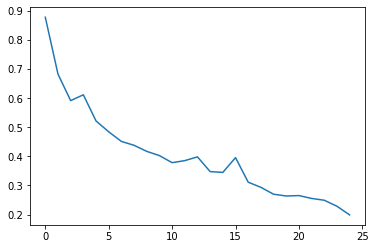

Epoch 1/25
17/17 - 2s - loss: 0.7984 - accuracy: 0.6081 - auc_19: 0.6275 - precision_19: 0.5985 - recall_19: 0.6165 - f1_score: 0.6592 - val_loss: 3.9420 - val_accuracy: 0.5277 - val_auc_19: 0.5283 - val_precision_19: 0.5281 - val_recall_19: 0.9860 - val_f1_score: 0.6908 - 2s/epoch - 101ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6784 - accuracy: 0.6673 - auc_19: 0.7173 - precision_19: 0.6693 - recall_19: 0.6391 - f1_score: 0.6592 - val_loss: 5.0880 - val_accuracy: 0.5277 - val_auc_19: 0.5039 - val_precision_19: 0.5277 - val_recall_19: 1.0000 - val_f1_score: 0.6908 - 455ms/epoch - 27ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6271 - accuracy: 0.6765 - auc_19: 0.7343 - precision_19: 0.6936 - recall_19: 0.6128 - f1_score: 0.6592 - val_loss: 5.5010 - val_accuracy: 0.5277 - val_auc_19: 0.5039 - val_precision_19: 0.5277 - val_recall_19: 1.0000 - val_f1_score: 0.6908 - 484ms/epoch - 28ms/step
Epoch 4/25
17/17 - 1s - loss: 0.5757 - accuracy: 0.6784 - auc_19: 0.7686 - precision_19: 0.6586 - recall_19:

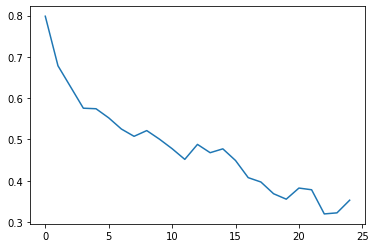

Epoch 1/25
17/17 - 2s - loss: 0.9044 - accuracy: 0.5812 - auc_20: 0.6258 - precision_20: 0.5788 - recall_20: 0.5852 - f1_score: 0.6650 - val_loss: 6.4805 - val_accuracy: 0.5148 - val_auc_20: 0.5095 - val_precision_20: 0.5148 - val_recall_20: 1.0000 - val_f1_score: 0.6797 - 2s/epoch - 120ms/step
Epoch 2/25
17/17 - 0s - loss: 0.6592 - accuracy: 0.6771 - auc_20: 0.7090 - precision_20: 0.6863 - recall_20: 0.6481 - f1_score: 0.6650 - val_loss: 2.5528 - val_accuracy: 0.5148 - val_auc_20: 0.5882 - val_precision_20: 0.5154 - val_recall_20: 0.9640 - val_f1_score: 0.6797 - 474ms/epoch - 28ms/step
Epoch 3/25
17/17 - 0s - loss: 0.6357 - accuracy: 0.6716 - auc_20: 0.7191 - precision_20: 0.6679 - recall_20: 0.6778 - f1_score: 0.6650 - val_loss: 1.0463 - val_accuracy: 0.6000 - val_auc_20: 0.6234 - val_precision_20: 0.5886 - val_recall_20: 0.7410 - val_f1_score: 0.6797 - 486ms/epoch - 29ms/step
Epoch 4/25
17/17 - 0s - loss: 0.6033 - accuracy: 0.6863 - auc_20: 0.7502 - precision_20: 0.6761 - recall_20:

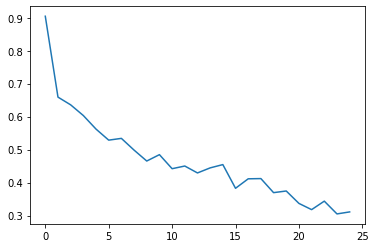

In [39]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs, binary=True)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [40]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 51.84% 
ROC/AUC: 0.70 
Precision: 0.91 
Recall: 0.48 
F1 score: 0.91


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

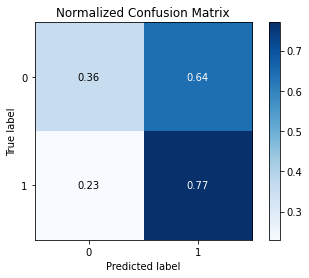

In [36]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figzize=(10, 8))

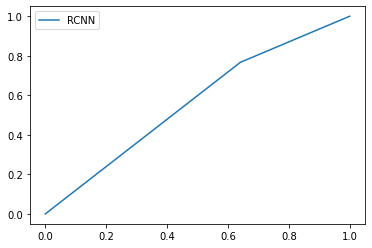

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [72]:
X_train, X_test, y_train, y_test = load_dataset('skeleton')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(812, 1, 350, 35) (812, 7)
(245, 1, 350, 35) (245, 7)


In [73]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [74]:
classes = get_class_names('skeleton')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               403
LowerBody Mild        164
LowerBody Moderate    103
UpperBody Mild         75
UpperBody Moderate     64
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [75]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.48
Weight for class "Lower Body Mild Pain": 3.94
Weight for class "Lower Body Moderate Pain": 406.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.41
Weight for class "Upper Body Severe Pain": 6.34
Weight for class "Lower Body Severe Pain": 203.00


#### CNN + Bidirectional LSTM

In [104]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 50s - loss: 1799.8539 - accuracy: 0.1479 - auc_45: 0.5052 - precision_45: 0.1481 - recall_45: 0.1479 - f1_score: 0.1083 - val_loss: 298.8817 - val_accuracy: 0.0148 - val_auc_45: 0.4260 - val_precision_45: 0.0148 - val_recall_45: 0.0148 - val_f1_score: 0.0076 - 50s/epoch - 3s/step
Epoch 2/25
17/17 - 41s - loss: 1271.2504 - accuracy: 0.1904 - auc_45: 0.5334 - precision_45: 0.1904 - recall_45: 0.1904 - f1_score: 0.1020 - val_loss: 78.4040 - val_accuracy: 0.0701 - val_auc_45: 0.4556 - val_precision_45: 0.0701 - val_recall_45: 0.0701 - val_f1_score: 0.0270 - 41s/epoch - 2s/step
Epoch 3/25
17/17 - 35s - loss: 555.6653 - accuracy: 0.2292 - auc_45: 0.5601 - precision_45: 0.2292 - recall_45: 0.2292 - f1_score: 0.1171 - val_loss: 118.7817 - val_accuracy: 0.1365 - val_auc_45: 0.4919 - val_precision_45: 0.1365 - val_recall_45: 0.1365 - val_f1_score: 0.0352 - 35s/epoch - 2s/step
Epoch 4/25
17/17 - 31s - loss: 476.6068 - accuracy: 0.1848 - auc_45: 0.5285 - precision_45: 0.1848 - r

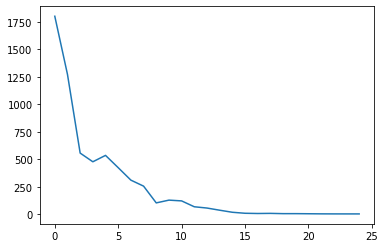

Epoch 1/25
17/17 - 43s - loss: 950.7426 - accuracy: 0.2625 - auc_46: 0.5728 - precision_46: 0.2635 - recall_46: 0.2625 - f1_score: 0.1426 - val_loss: 62.4739 - val_accuracy: 0.1919 - val_auc_46: 0.5286 - val_precision_46: 0.1919 - val_recall_46: 0.1919 - val_f1_score: 0.0460 - 43s/epoch - 3s/step
Epoch 2/25
17/17 - 37s - loss: 256.2959 - accuracy: 0.1534 - auc_46: 0.5120 - precision_46: 0.1534 - recall_46: 0.1534 - f1_score: 0.1077 - val_loss: 76.7550 - val_accuracy: 0.1808 - val_auc_46: 0.5325 - val_precision_46: 0.1815 - val_recall_46: 0.1808 - val_f1_score: 0.0753 - 37s/epoch - 2s/step
Epoch 3/25
17/17 - 32s - loss: 452.3407 - accuracy: 0.2458 - auc_46: 0.5666 - precision_46: 0.2463 - recall_46: 0.2458 - f1_score: 0.1170 - val_loss: 66.1742 - val_accuracy: 0.1919 - val_auc_46: 0.5282 - val_precision_46: 0.1919 - val_recall_46: 0.1919 - val_f1_score: 0.0461 - 32s/epoch - 2s/step
Epoch 4/25
17/17 - 32s - loss: 188.7230 - accuracy: 0.1922 - auc_46: 0.5321 - precision_46: 0.1926 - recal

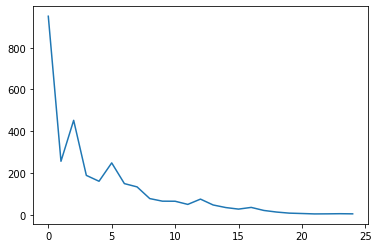

Epoch 1/25
17/17 - 45s - loss: 1015.6202 - accuracy: 0.1716 - auc_47: 0.5094 - precision_47: 0.1716 - recall_47: 0.1716 - f1_score: 0.1232 - val_loss: 82.0457 - val_accuracy: 0.2074 - val_auc_47: 0.5377 - val_precision_47: 0.2074 - val_recall_47: 0.2074 - val_f1_score: 0.0491 - 45s/epoch - 3s/step
Epoch 2/25
17/17 - 35s - loss: 945.2342 - accuracy: 0.1587 - auc_47: 0.5138 - precision_47: 0.1587 - recall_47: 0.1587 - f1_score: 0.1011 - val_loss: 265.6077 - val_accuracy: 0.0926 - val_auc_47: 0.4707 - val_precision_47: 0.0926 - val_recall_47: 0.0926 - val_f1_score: 0.0242 - 35s/epoch - 2s/step
Epoch 3/25
17/17 - 31s - loss: 797.4583 - accuracy: 0.1070 - auc_47: 0.4753 - precision_47: 0.1070 - recall_47: 0.1070 - f1_score: 0.0741 - val_loss: 296.3863 - val_accuracy: 0.0926 - val_auc_47: 0.4707 - val_precision_47: 0.0926 - val_recall_47: 0.0926 - val_f1_score: 0.0242 - 31s/epoch - 2s/step
Epoch 4/25
17/17 - 33s - loss: 609.4073 - accuracy: 0.1199 - auc_47: 0.4903 - precision_47: 0.1201 - re

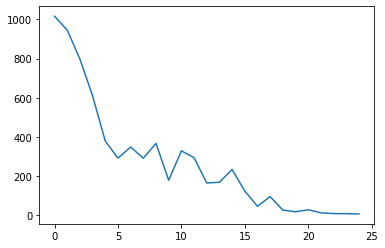

In [105]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on holdout set

In [106]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 16.73% 
Balanced Accuracy: 12.67% 
ROC/AUC: 0.54 
Precision: 0.15 
Recall: 0.14 
F1 score: 0.10


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

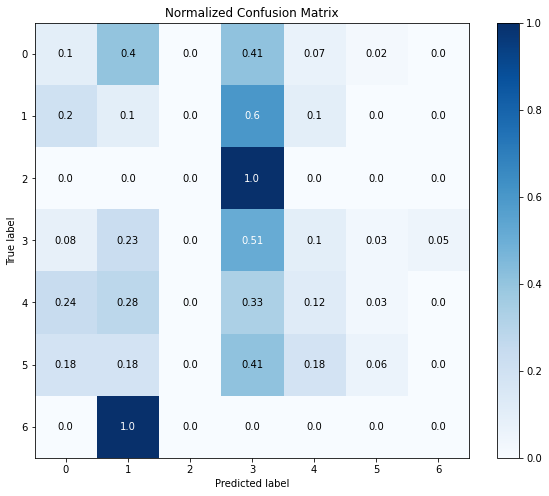

In [121]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

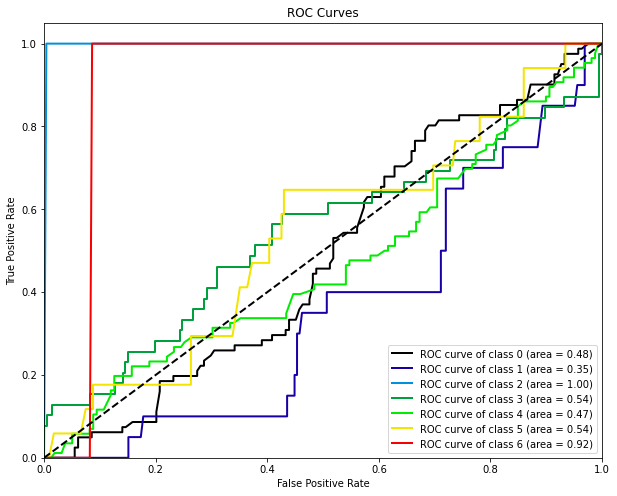

In [120]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [100]:
class RCNN():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 18.5146 - accuracy: 0.2107 - auc_42: 0.6097 - precision_42: 0.2173 - recall_42: 0.1257 - f1_score: 0.1445 - val_loss: 41.0885 - val_accuracy: 0.0517 - val_auc_42: 0.4484 - val_precision_42: 0.0517 - val_recall_42: 0.0517 - val_f1_score: 0.0140 - 2s/epoch - 119ms/step
Epoch 2/25
17/17 - 1s - loss: 12.5212 - accuracy: 0.1590 - auc_42: 0.5913 - precision_42: 0.1599 - recall_42: 0.0943 - f1_score: 0.1197 - val_loss: 9.7295 - val_accuracy: 0.0701 - val_auc_42: 0.4961 - val_precision_42: 0.0640 - val_recall_42: 0.0590 - val_f1_score: 0.0423 - 713ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 5.9271 - accuracy: 0.3235 - auc_42: 0.7110 - precision_42: 0.3395 - recall_42: 0.1349 - f1_score: 0.2279 - val_loss: 8.3192 - val_accuracy: 0.0886 - val_auc_42: 0.4627 - val_precision_42: 0.0896 - val_recall_42: 0.0886 - val_f1_score: 0.0332 - 703ms/epoch - 41ms/step
Epoch 4/25
17/17 - 1s - loss: 4.6451 - accuracy: 0.3235 - auc_42: 0.7473 - precision_42: 0.4229 - recall_

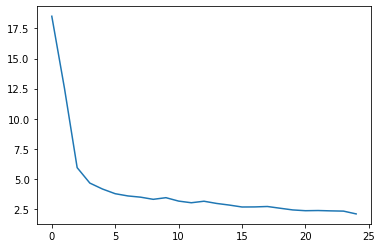

Epoch 1/25
17/17 - 2s - loss: 11.1419 - accuracy: 0.2089 - auc_43: 0.6131 - precision_43: 0.2123 - recall_43: 0.1405 - f1_score: 0.1372 - val_loss: 13.8218 - val_accuracy: 0.0923 - val_auc_43: 0.4789 - val_precision_43: 0.0923 - val_recall_43: 0.0923 - val_f1_score: 0.0245 - 2s/epoch - 113ms/step
Epoch 2/25
17/17 - 1s - loss: 5.0401 - accuracy: 0.3457 - auc_43: 0.7292 - precision_43: 0.3509 - recall_43: 0.1719 - f1_score: 0.2362 - val_loss: 18.0712 - val_accuracy: 0.1218 - val_auc_43: 0.4877 - val_precision_43: 0.1218 - val_recall_43: 0.1218 - val_f1_score: 0.0310 - 691ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 4.0317 - accuracy: 0.4418 - auc_43: 0.8087 - precision_43: 0.5907 - recall_43: 0.2107 - f1_score: 0.3094 - val_loss: 5.1113 - val_accuracy: 0.1218 - val_auc_43: 0.5897 - val_precision_43: 0.1227 - val_recall_43: 0.1218 - val_f1_score: 0.0356 - 703ms/epoch - 41ms/step
Epoch 4/25
17/17 - 1s - loss: 3.7869 - accuracy: 0.4529 - auc_43: 0.8076 - precision_43: 0.5091 - recall_

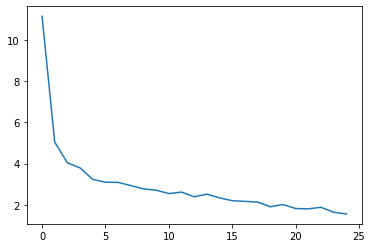

Epoch 1/25
17/17 - 2s - loss: 14.4535 - accuracy: 0.2288 - auc_44: 0.6589 - precision_44: 0.1968 - recall_44: 0.1125 - f1_score: 0.1460 - val_loss: 28.4533 - val_accuracy: 0.1185 - val_auc_44: 0.4801 - val_precision_44: 0.1185 - val_recall_44: 0.1185 - val_f1_score: 0.0304 - 2s/epoch - 114ms/step
Epoch 2/25
17/17 - 1s - loss: 6.6124 - accuracy: 0.3118 - auc_44: 0.7179 - precision_44: 0.3231 - recall_44: 0.1365 - f1_score: 0.2065 - val_loss: 12.7411 - val_accuracy: 0.0926 - val_auc_44: 0.4421 - val_precision_44: 0.0958 - val_recall_44: 0.0926 - val_f1_score: 0.0314 - 697ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 4.2459 - accuracy: 0.3229 - auc_44: 0.7544 - precision_44: 0.3627 - recall_44: 0.1292 - f1_score: 0.2500 - val_loss: 8.0377 - val_accuracy: 0.1778 - val_auc_44: 0.5207 - val_precision_44: 0.1786 - val_recall_44: 0.1667 - val_f1_score: 0.0767 - 759ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 3.5566 - accuracy: 0.4188 - auc_44: 0.8133 - precision_44: 0.5381 - recall_

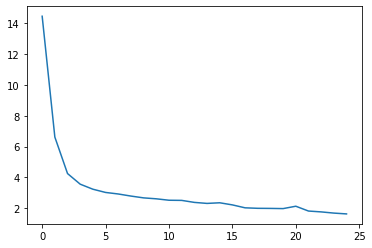

In [101]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [102]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 17.96% 
Balanced Accuracy: 15.46% 
ROC/AUC: 0.63 
Precision: 0.18 
Recall: 0.13 
F1 score: 0.12


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

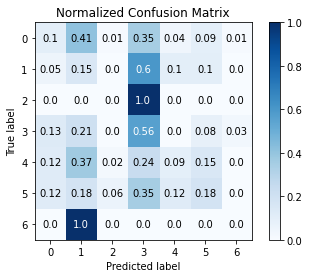

In [103]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

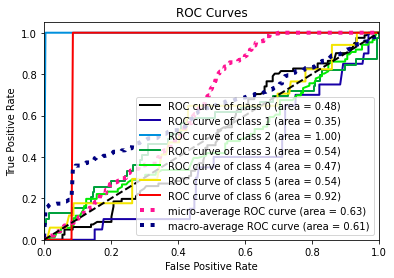

In [114]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 2. Unimodal Face Modality (Action Units + Head Pose)

### Binary Classification

#### Dataset

In [122]:
X_train, X_test, y_train, y_test = load_dataset('AUs', binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 25) (782, 1)
(238, 1, 350, 25) (238, 1)


In [123]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [124]:
class CNNLSTM():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='relu'))(flatten)
        dense = Dense(64, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 4s - loss: 19587.1191 - accuracy: 0.5010 - auc_48: 0.4933 - precision_48: 0.5299 - recall_48: 0.6321 - f1_score: 0.5921 - val_loss: 8473.3438 - val_accuracy: 0.4406 - val_auc_48: 0.5000 - val_precision_48: 0.4406 - val_recall_48: 1.0000 - val_f1_score: 0.6117 - 4s/epoch - 233ms/step
Epoch 2/25
17/17 - 1s - loss: 10621.0947 - accuracy: 0.4818 - auc_48: 0.4482 - precision_48: 0.5127 - recall_48: 0.7214 - f1_score: 0.6711 - val_loss: 4517.9160 - val_accuracy: 0.4023 - val_auc_48: 0.4118 - val_precision_48: 0.4072 - val_recall_48: 0.7826 - val_f1_score: 0.6039 - 772ms/epoch - 45ms/step
Epoch 3/25
17/17 - 1s - loss: 4310.9858 - accuracy: 0.4722 - auc_48: 0.4826 - precision_48: 0.5143 - recall_48: 0.3214 - f1_score: 0.5823 - val_loss: 1173.1968 - val_accuracy: 0.5824 - val_auc_48: 0.5206 - val_precision_48: 0.7500 - val_recall_48: 0.0783 - val_f1_score: 0.5263 - 774ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 5017.8833 - accuracy: 0.5202 - auc_48: 0.5138 - precision_

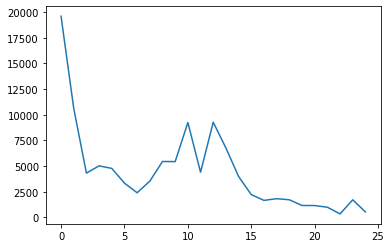

Epoch 1/25
17/17 - 5s - loss: 12692.0068 - accuracy: 0.5451 - auc_49: 0.5391 - precision_49: 0.5342 - recall_49: 0.4643 - f1_score: 0.6055 - val_loss: 6437.7847 - val_accuracy: 0.4866 - val_auc_49: 0.5532 - val_precision_49: 0.5849 - val_recall_49: 0.2168 - val_f1_score: 0.7074 - 5s/epoch - 317ms/step
Epoch 2/25
17/17 - 1s - loss: 5630.1660 - accuracy: 0.4798 - auc_49: 0.4585 - precision_49: 0.4532 - recall_49: 0.3651 - f1_score: 0.5705 - val_loss: 6100.2808 - val_accuracy: 0.5364 - val_auc_49: 0.4764 - val_precision_49: 0.5455 - val_recall_49: 0.9231 - val_f1_score: 0.7068 - 788ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 2488.4175 - accuracy: 0.4779 - auc_49: 0.4772 - precision_49: 0.4773 - recall_49: 0.8333 - f1_score: 0.6430 - val_loss: 27353.2930 - val_accuracy: 0.5556 - val_auc_49: 0.5085 - val_precision_49: 0.5521 - val_recall_49: 1.0000 - val_f1_score: 0.7114 - 834ms/epoch - 49ms/step
Epoch 4/25
17/17 - 1s - loss: 1254.1544 - accuracy: 0.4914 - auc_49: 0.5074 - precision_

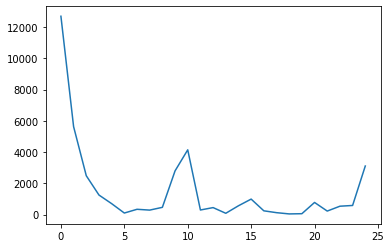

Epoch 1/25
17/17 - 3s - loss: 15820.5586 - accuracy: 0.5077 - auc_50: 0.5080 - precision_50: 0.5016 - recall_50: 0.5969 - f1_score: 0.5776 - val_loss: 16944.8027 - val_accuracy: 0.4577 - val_auc_50: 0.4833 - val_precision_50: 0.1667 - val_recall_50: 0.0073 - val_f1_score: 0.0140 - 3s/epoch - 184ms/step
Epoch 2/25
17/17 - 1s - loss: 27000.3301 - accuracy: 0.4732 - auc_50: 0.4754 - precision_50: 0.4573 - recall_50: 0.3527 - f1_score: 0.4237 - val_loss: 13979.6025 - val_accuracy: 0.5269 - val_auc_50: 0.5000 - val_precision_50: 0.5269 - val_recall_50: 1.0000 - val_f1_score: 0.6902 - 722ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 8283.6924 - accuracy: 0.5364 - auc_50: 0.5343 - precision_50: 0.5360 - recall_50: 0.4612 - f1_score: 0.5128 - val_loss: 6138.0493 - val_accuracy: 0.4654 - val_auc_50: 0.4910 - val_precision_50: 0.3333 - val_recall_50: 0.0146 - val_f1_score: 0.0280 - 708ms/epoch - 42ms/step
Epoch 4/25
17/17 - 1s - loss: 3203.5432 - accuracy: 0.5307 - auc_50: 0.5316 - precisio

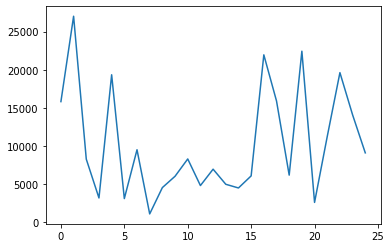

In [125]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [127]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 17.65% 
ROC/AUC: 0.51 
Precision: 1.00 
Recall: 0.03 
F1 score: 0.06


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

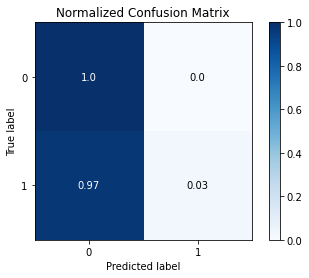

In [128]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10, 8))

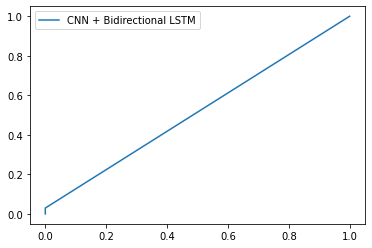

In [129]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [135]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 1.1790 - accuracy: 0.5278 - auc_53: 0.5279 - precision_53: 0.5512 - recall_53: 0.6536 - f1_score: 0.6991 - val_loss: 0.7514 - val_accuracy: 0.4368 - val_auc_53: 0.4447 - val_precision_53: 0.4380 - val_recall_53: 0.9826 - val_f1_score: 0.6117 - 2s/epoch - 129ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8479 - accuracy: 0.5182 - auc_53: 0.5540 - precision_53: 0.5759 - recall_53: 0.3929 - f1_score: 0.7000 - val_loss: 0.9279 - val_accuracy: 0.4253 - val_auc_53: 0.4817 - val_precision_53: 0.4314 - val_recall_53: 0.9565 - val_f1_score: 0.6080 - 717ms/epoch - 42ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7674 - accuracy: 0.5528 - auc_53: 0.5237 - precision_53: 0.5564 - recall_53: 0.8286 - f1_score: 0.7000 - val_loss: 0.8463 - val_accuracy: 0.4330 - val_auc_53: 0.4990 - val_precision_53: 0.4358 - val_recall_53: 0.9739 - val_f1_score: 0.6117 - 688ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7433 - accuracy: 0.5681 - auc_53: 0.5531 - precision_53: 0.5775 - recall_53:

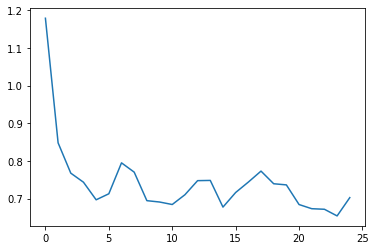

Epoch 1/25
17/17 - 2s - loss: 1.6049 - accuracy: 0.4971 - auc_54: 0.4758 - precision_54: 0.4615 - recall_54: 0.2381 - f1_score: 0.6520 - val_loss: 0.7778 - val_accuracy: 0.4521 - val_auc_54: 0.5089 - val_precision_54: 0.5000 - val_recall_54: 0.0070 - val_f1_score: 0.7079 - 2s/epoch - 139ms/step
Epoch 2/25
17/17 - 1s - loss: 0.9162 - accuracy: 0.5413 - auc_54: 0.5650 - precision_54: 0.5175 - recall_54: 0.7619 - f1_score: 0.6545 - val_loss: 1.2699 - val_accuracy: 0.4559 - val_auc_54: 0.5152 - val_precision_54: 0.6000 - val_recall_54: 0.0210 - val_f1_score: 0.7079 - 852ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 0.8640 - accuracy: 0.5393 - auc_54: 0.5532 - precision_54: 0.6200 - recall_54: 0.1230 - f1_score: 0.6537 - val_loss: 0.9517 - val_accuracy: 0.4559 - val_auc_54: 0.4997 - val_precision_54: 0.6000 - val_recall_54: 0.0210 - val_f1_score: 0.7079 - 772ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6941 - accuracy: 0.5777 - auc_54: 0.6154 - precision_54: 0.7162 - recall_54:

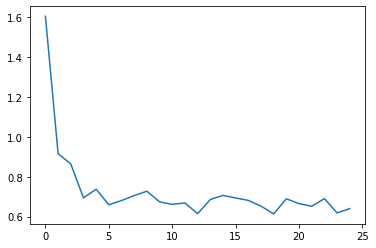

Epoch 1/25
17/17 - 4s - loss: 1.2185 - accuracy: 0.5326 - auc_55: 0.5464 - precision_55: 0.5271 - recall_55: 0.5271 - f1_score: 0.6598 - val_loss: 1.1299 - val_accuracy: 0.4731 - val_auc_55: 0.5426 - val_precision_55: 0.5000 - val_recall_55: 0.0146 - val_f1_score: 0.6902 - 4s/epoch - 230ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8667 - accuracy: 0.5498 - auc_55: 0.5591 - precision_55: 0.5615 - recall_55: 0.4070 - f1_score: 0.6615 - val_loss: 0.7595 - val_accuracy: 0.5385 - val_auc_55: 0.5112 - val_precision_55: 0.5331 - val_recall_55: 1.0000 - val_f1_score: 0.6902 - 810ms/epoch - 48ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7317 - accuracy: 0.5536 - auc_55: 0.5902 - precision_55: 0.5598 - recall_55: 0.4535 - f1_score: 0.6615 - val_loss: 0.7556 - val_accuracy: 0.5385 - val_auc_55: 0.5142 - val_precision_55: 0.5331 - val_recall_55: 1.0000 - val_f1_score: 0.6902 - 903ms/epoch - 53ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6948 - accuracy: 0.5805 - auc_55: 0.6177 - precision_55: 0.5546 - recall_55:

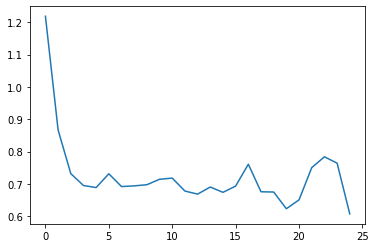

In [136]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Evaluation on the holdout set

In [137]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 18.91% 
ROC/AUC: 0.62 
Precision: 1.00 
Recall: 0.04 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

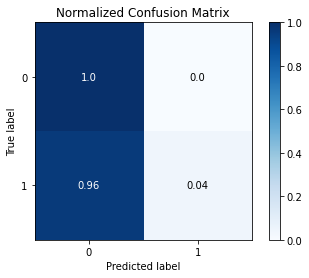

In [138]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, figsize=(10,8))

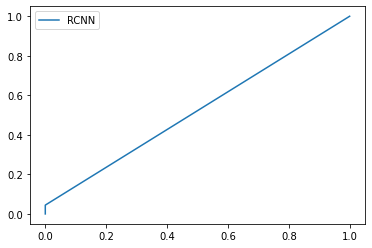

In [139]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [140]:
X_train, X_test, y_train, y_test = load_dataset('AUs')
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 25) (782, 7)
(238, 1, 350, 25) (238, 7)


In [141]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

In [27]:
classes = get_class_names('AUs')
tmp = pd.DataFrame(classes)
classes = tmp.value_counts()
classes

No Pain               387
LowerBody Mild        157
LowerBody Moderate    100
UpperBody Mild         74
UpperBody Moderate     61
UpperBody Severe        2
LowerBody Severe        1
dtype: int64

In [28]:
nopain, lbmild, lbmod, ubmild, ubmod, ubsevere, lbsevere = np.sum(y, axis=0)
total = nopain + ubmild + lbmod + lbmild + ubmod + ubsevere + lbsevere

weight_for_lbmild = (1 / lbmild) * (total / 2.0)
weight_for_lbmod = (1 / lbmod) * (total / 2.0)
weight_for_nopain = (1 / nopain) * (total / 2.0)
weight_for_ubmild = (1 / ubmild) * (total / 2.0)
weight_for_ubmod = (1 / ubmod) * (total / 2.0)
weight_for_lbsevere = (1 / lbsevere) * (total / 2.0)
weight_for_ubsevere = (1 / ubsevere) * (total / 2.0)

class_weight = {0: weight_for_nopain, 1: weight_for_lbmild, 2: weight_for_lbmod, 3: weight_for_ubmild, 4: weight_for_ubmod, 5: weight_for_ubsevere, 6: weight_for_lbsevere}

print('Weight for class "No Pain": {:.2f}'.format(weight_for_nopain))
print('Weight for class "Lower Body Mild Pain": {:.2f}'.format(weight_for_lbmild))
print('Weight for class "Lower Body Moderate Pain": {:.2f}'.format(weight_for_lbmod))
print('Weight for class "Upper Body Mild Pain": {:.2f}'.format(weight_for_ubmild))
print('Weight for class "Upper Body Moderate Pain": {:.2f}'.format(weight_for_ubmod))
print('Weight for class "Upper Body Severe Pain": {:.2f}'.format(weight_for_ubsevere))
print('Weight for class "Lower Body Severe Pain": {:.2f}'.format(weight_for_lbsevere))

Weight for class "No Pain": 2.49
Weight for class "Lower Body Mild Pain": 3.91
Weight for class "Lower Body Moderate Pain": 391.00
Weight for class "Upper Body Mild Pain": 1.01
Weight for class "Upper Body Moderate Pain": 5.28
Weight for class "Upper Body Severe Pain": 6.41
Weight for class "Lower Body Severe Pain": 195.50


#### CNN + Bidirectional LSTM

In [144]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 48s - loss: 625232.1875 - accuracy: 0.1651 - auc_56: 0.5119 - precision_56: 0.1651 - recall_56: 0.1651 - f1_score: 0.1278 - val_loss: 150249.6875 - val_accuracy: 0.1264 - val_auc_56: 0.4899 - val_precision_56: 0.1264 - val_recall_56: 0.1264 - val_f1_score: 0.0329 - 48s/epoch - 3s/step
Epoch 2/25
17/17 - 41s - loss: 369213.6562 - accuracy: 0.0825 - auc_56: 0.4637 - precision_56: 0.0825 - recall_56: 0.0825 - f1_score: 0.0688 - val_loss: 51872.1719 - val_accuracy: 0.1494 - val_auc_56: 0.5004 - val_precision_56: 0.1494 - val_recall_56: 0.1494 - val_f1_score: 0.0692 - 41s/epoch - 2s/step
Epoch 3/25
17/17 - 42s - loss: 295040.6250 - accuracy: 0.1996 - auc_56: 0.5325 - precision_56: 0.1996 - recall_56: 0.1996 - f1_score: 0.0936 - val_loss: 345500.7188 - val_accuracy: 0.4521 - val_auc_56: 0.6834 - val_precision_56: 0.4521 - val_recall_56: 0.4521 - val_f1_score: 0.1219 - 42s/epoch - 2s/step
Epoch 4/25
17/17 - 35s - loss: 359228.5938 - accuracy: 0.2111 - auc_56: 0.5403 - preci

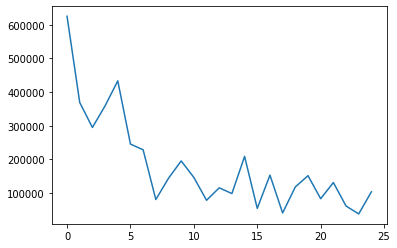

Epoch 1/25
17/17 - 42s - loss: 385212.5938 - accuracy: 0.1612 - auc_57: 0.5121 - precision_57: 0.1612 - recall_57: 0.1612 - f1_score: 0.1054 - val_loss: 349269.2500 - val_accuracy: 0.0996 - val_auc_57: 0.4748 - val_precision_57: 0.0996 - val_recall_57: 0.0996 - val_f1_score: 0.0330 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 96387.7109 - accuracy: 0.1363 - auc_57: 0.4967 - precision_57: 0.1363 - recall_57: 0.1363 - f1_score: 0.0584 - val_loss: 477445.9062 - val_accuracy: 0.3755 - val_auc_57: 0.6406 - val_precision_57: 0.3755 - val_recall_57: 0.3755 - val_f1_score: 0.0828 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 32s - loss: 252925.2500 - accuracy: 0.1113 - auc_57: 0.4812 - precision_57: 0.1113 - recall_57: 0.1113 - f1_score: 0.0695 - val_loss: 519432.9375 - val_accuracy: 0.0920 - val_auc_57: 0.4717 - val_precision_57: 0.0920 - val_recall_57: 0.0920 - val_f1_score: 0.0351 - 32s/epoch - 2s/step
Epoch 4/25
17/17 - 35s - loss: 89937.8281 - accuracy: 0.3647 - auc_57: 0.6291 - precis

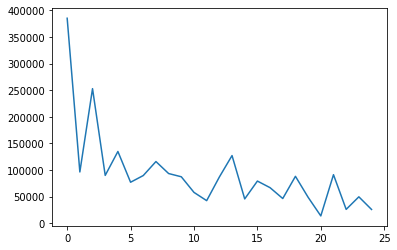

Epoch 1/25
17/17 - 42s - loss: 858278.3125 - accuracy: 0.2356 - auc_58: 0.5558 - precision_58: 0.2356 - recall_58: 0.2356 - f1_score: 0.1041 - val_loss: 107185.8906 - val_accuracy: 0.0962 - val_auc_58: 0.4712 - val_precision_58: 0.0962 - val_recall_58: 0.0962 - val_f1_score: 0.0336 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 332044.9375 - accuracy: 0.1054 - auc_58: 0.4779 - precision_58: 0.1054 - recall_58: 0.1054 - f1_score: 0.0618 - val_loss: 44847.2500 - val_accuracy: 0.1346 - val_auc_58: 0.4952 - val_precision_58: 0.1346 - val_recall_58: 0.1346 - val_f1_score: 0.0381 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 30s - loss: 668366.3750 - accuracy: 0.4253 - auc_58: 0.6663 - precision_58: 0.4253 - recall_58: 0.4253 - f1_score: 0.1229 - val_loss: 75666.5234 - val_accuracy: 0.0692 - val_auc_58: 0.4571 - val_precision_58: 0.0692 - val_recall_58: 0.0692 - val_f1_score: 0.0228 - 30s/epoch - 2s/step
Epoch 4/25
17/17 - 30s - loss: 523361.6562 - accuracy: 0.0958 - auc_58: 0.4725 - precis

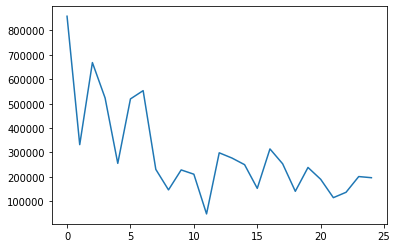

In [145]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [146]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 29.41% 
Balanced Accuracy: 15.76% 
ROC/AUC: 0.60 
Precision: 0.29 
Recall: 0.29 
F1 score: 0.13


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

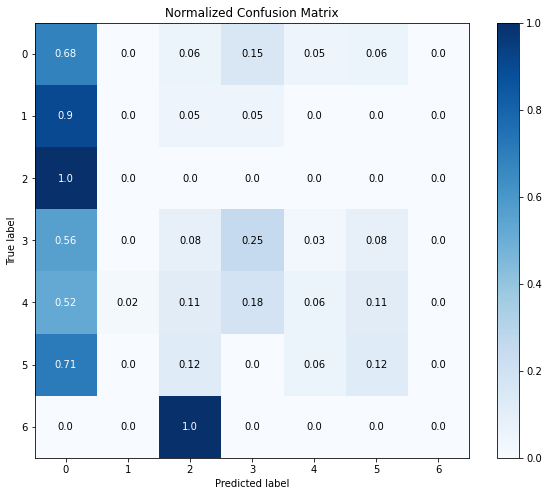

In [147]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

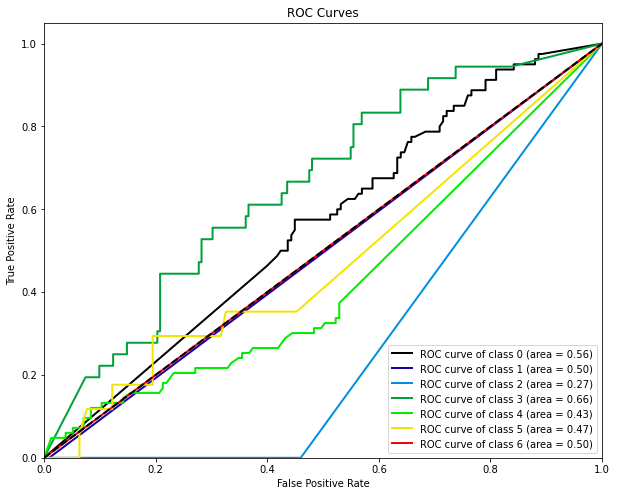

In [148]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [149]:
class RCNN():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 3s - loss: 17.6020 - accuracy: 0.0614 - auc_59: 0.4342 - precision_59: 0.1034 - recall_59: 0.0230 - f1_score: 0.0499 - val_loss: 3.4856 - val_accuracy: 0.0843 - val_auc_59: 0.2258 - val_precision_59: 0.3333 - val_recall_59: 0.0077 - val_f1_score: 0.0403 - 3s/epoch - 169ms/step
Epoch 2/25
17/17 - 1s - loss: 14.8506 - accuracy: 0.1017 - auc_59: 0.4375 - precision_59: 0.1333 - recall_59: 0.0499 - f1_score: 0.0691 - val_loss: 3.5411 - val_accuracy: 0.0766 - val_auc_59: 0.4019 - val_precision_59: 0.1667 - val_recall_59: 0.0038 - val_f1_score: 0.0267 - 684ms/epoch - 40ms/step
Epoch 3/25
17/17 - 1s - loss: 10.5061 - accuracy: 0.1363 - auc_59: 0.5023 - precision_59: 0.1278 - recall_59: 0.0326 - f1_score: 0.0903 - val_loss: 2.5602 - val_accuracy: 0.1456 - val_auc_59: 0.4614 - val_precision_59: 0.3333 - val_recall_59: 0.0077 - val_f1_score: 0.0378 - 662ms/epoch - 39ms/step
Epoch 4/25
17/17 - 1s - loss: 8.5657 - accuracy: 0.2073 - auc_59: 0.5962 - precision_59: 0.1184 - recall_

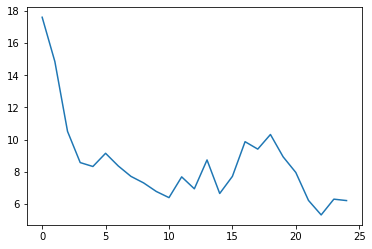

Epoch 1/25
17/17 - 2s - loss: 14.5172 - accuracy: 0.1651 - auc_60: 0.5921 - precision_60: 0.1449 - recall_60: 0.0384 - f1_score: 0.1002 - val_loss: 4.9926 - val_accuracy: 0.4483 - val_auc_60: 0.7397 - val_precision_60: 0.4286 - val_recall_60: 0.0115 - val_f1_score: 0.0932 - 2s/epoch - 115ms/step
Epoch 2/25
17/17 - 1s - loss: 7.3824 - accuracy: 0.1766 - auc_60: 0.5886 - precision_60: 0.1809 - recall_60: 0.0653 - f1_score: 0.1074 - val_loss: 3.3785 - val_accuracy: 0.1188 - val_auc_60: 0.5255 - val_precision_60: 0.2857 - val_recall_60: 0.0077 - val_f1_score: 0.0339 - 692ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 6.0798 - accuracy: 0.2284 - auc_60: 0.6331 - precision_60: 0.2483 - recall_60: 0.0691 - f1_score: 0.1357 - val_loss: 3.2365 - val_accuracy: 0.1226 - val_auc_60: 0.6417 - val_precision_60: 0.4286 - val_recall_60: 0.0115 - val_f1_score: 0.0385 - 685ms/epoch - 40ms/step
Epoch 4/25
17/17 - 1s - loss: 6.2429 - accuracy: 0.3666 - auc_60: 0.7484 - precision_60: 0.4729 - recall_60

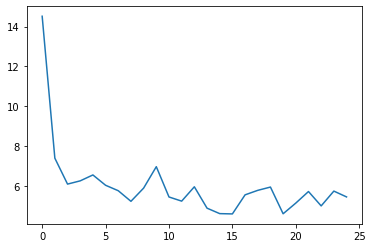

Epoch 1/25
17/17 - 2s - loss: 12.4949 - accuracy: 0.2184 - auc_61: 0.5821 - precision_61: 0.1394 - recall_61: 0.0441 - f1_score: 0.1311 - val_loss: 3.5187 - val_accuracy: 0.4577 - val_auc_61: 0.7224 - val_precision_61: 0.1429 - val_recall_61: 0.0038 - val_f1_score: 0.0941 - 2s/epoch - 115ms/step
Epoch 2/25
17/17 - 1s - loss: 7.5248 - accuracy: 0.2280 - auc_61: 0.6633 - precision_61: 0.3062 - recall_61: 0.1226 - f1_score: 0.1301 - val_loss: 3.0198 - val_accuracy: 0.4654 - val_auc_61: 0.7741 - val_precision_61: 0.4286 - val_recall_61: 0.0115 - val_f1_score: 0.0912 - 693ms/epoch - 41ms/step
Epoch 3/25
17/17 - 1s - loss: 9.4032 - accuracy: 0.2931 - auc_61: 0.6859 - precision_61: 0.2667 - recall_61: 0.0536 - f1_score: 0.1414 - val_loss: 2.5596 - val_accuracy: 0.0769 - val_auc_61: 0.5420 - val_precision_61: 0.5714 - val_recall_61: 0.0154 - val_f1_score: 0.0386 - 753ms/epoch - 44ms/step
Epoch 4/25
17/17 - 1s - loss: 8.2139 - accuracy: 0.1724 - auc_61: 0.5713 - precision_61: 0.2314 - recall_61

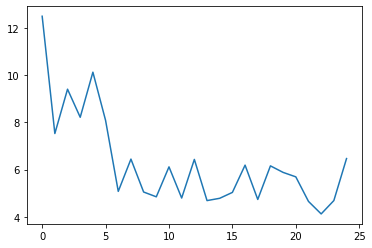

In [150]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [ ]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

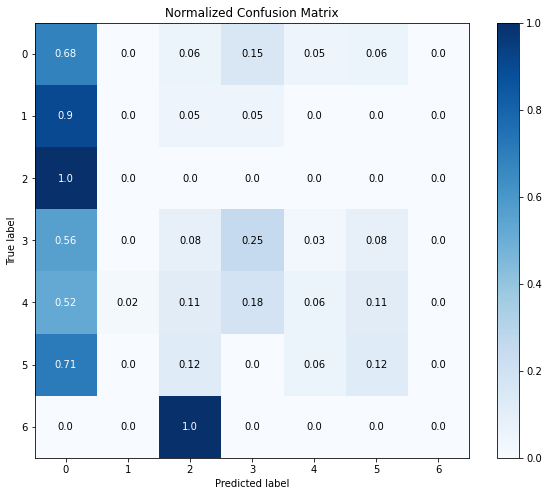

In [151]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

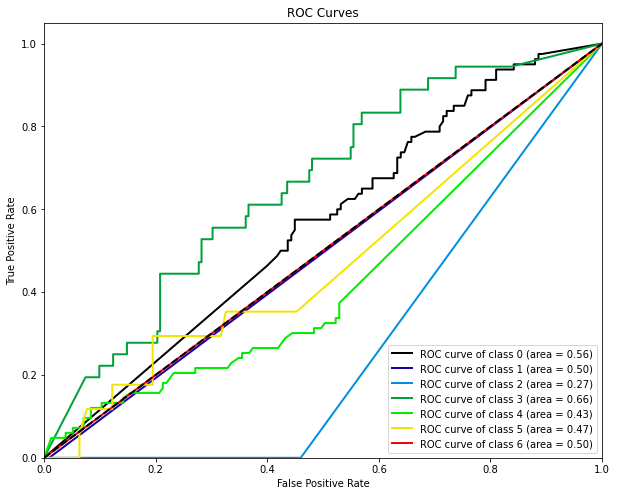

In [152]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 3. Multimodal Early Fusion

### Binary Classification

#### Dataset

In [2]:
X_train, X_test, y_train, y_test = load_fusioned_dataset(binary=True)
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 60) (782, 1)
(238, 1, 350, 60) (238, 1)


In [3]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [13]:
class CNNLSTM():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='tanh'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(64, activation='tanh'))(flatten)
        dense = Dense(64, activation='tanh')(lstm)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 5s - loss: 0.7340 - accuracy: 0.5202 - auc_4: 0.5396 - precision_4: 0.5221 - recall_4: 0.7105 - f1_score: 0.6760 - val_loss: 0.6854 - val_accuracy: 0.5517 - val_auc_4: 0.5985 - val_precision_4: 0.7143 - val_recall_4: 0.1550 - val_f1_score: 0.6615 - 5s/epoch - 304ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6905 - accuracy: 0.5221 - auc_4: 0.5868 - precision_4: 0.5914 - recall_4: 0.2068 - f1_score: 0.6760 - val_loss: 0.6958 - val_accuracy: 0.5211 - val_auc_4: 0.6009 - val_precision_4: 0.5082 - val_recall_4: 0.9612 - val_f1_score: 0.6615 - 773ms/epoch - 45ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6716 - accuracy: 0.5643 - auc_4: 0.6359 - precision_4: 0.5531 - recall_4: 0.7632 - f1_score: 0.6760 - val_loss: 0.6785 - val_accuracy: 0.5709 - val_auc_4: 0.6212 - val_precision_4: 0.6349 - val_recall_4: 0.3101 - val_f1_score: 0.6615 - 774ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6550 - accuracy: 0.6046 - auc_4: 0.6635 - precision_4: 0.6415 - recall_4: 0.5113 - f1_score: 0

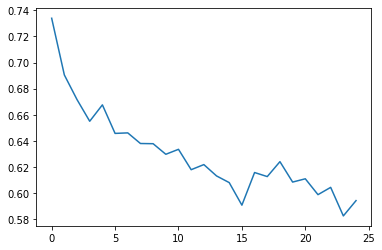

Epoch 1/25
17/17 - 4s - loss: 0.8002 - accuracy: 0.4971 - auc_5: 0.4926 - precision_5: 0.4942 - recall_5: 0.6550 - f1_score: 0.6624 - val_loss: 0.6997 - val_accuracy: 0.4789 - val_auc_5: 0.5826 - val_precision_5: 1.0000 - val_recall_5: 0.0073 - val_f1_score: 0.6884 - 4s/epoch - 247ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6948 - accuracy: 0.5067 - auc_5: 0.5250 - precision_5: 1.0000 - recall_5: 0.0039 - f1_score: 0.6624 - val_loss: 0.6940 - val_accuracy: 0.4674 - val_auc_5: 0.5943 - val_precision_5: 0.4167 - val_recall_5: 0.0365 - val_f1_score: 0.6884 - 789ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6883 - accuracy: 0.5777 - auc_5: 0.5833 - precision_5: 0.6557 - recall_5: 0.3101 - f1_score: 0.6624 - val_loss: 0.6899 - val_accuracy: 0.5211 - val_auc_5: 0.5785 - val_precision_5: 0.5857 - val_recall_5: 0.2993 - val_f1_score: 0.6884 - 777ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6807 - accuracy: 0.6027 - auc_5: 0.6317 - precision_5: 0.6835 - recall_5: 0.3682 - f1_score: 0

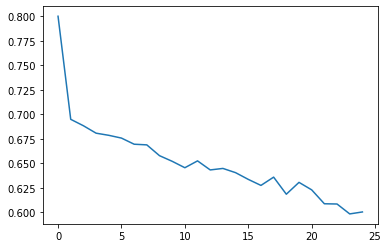

Epoch 1/25
17/17 - 5s - loss: 0.7166 - accuracy: 0.4713 - auc_6: 0.5194 - precision_6: 0.4734 - recall_6: 0.3346 - f1_score: 0.6751 - val_loss: 0.6654 - val_accuracy: 0.6308 - val_auc_6: 0.7144 - val_precision_6: 0.6025 - val_recall_6: 0.7519 - val_f1_score: 0.6632 - 5s/epoch - 278ms/step
Epoch 2/25
17/17 - 1s - loss: 0.6775 - accuracy: 0.5843 - auc_6: 0.6037 - precision_6: 0.5860 - recall_6: 0.6278 - f1_score: 0.6751 - val_loss: 0.6403 - val_accuracy: 0.6769 - val_auc_6: 0.7114 - val_precision_6: 0.7103 - val_recall_6: 0.5891 - val_f1_score: 0.6632 - 757ms/epoch - 45ms/step
Epoch 3/25
17/17 - 1s - loss: 0.6657 - accuracy: 0.6073 - auc_6: 0.6410 - precision_6: 0.6160 - recall_6: 0.6090 - f1_score: 0.6751 - val_loss: 0.6508 - val_accuracy: 0.6462 - val_auc_6: 0.7056 - val_precision_6: 0.6209 - val_recall_6: 0.7364 - val_f1_score: 0.6632 - 748ms/epoch - 44ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6587 - accuracy: 0.6073 - auc_6: 0.6529 - precision_6: 0.6027 - recall_6: 0.6729 - f1_score: 0

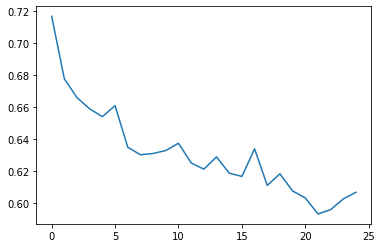

In [14]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [15]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 58.40% 
ROC/AUC: 0.70 
Precision: 0.93 
Recall: 0.55 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

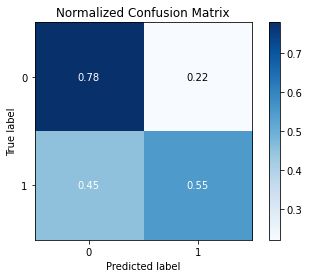

In [16]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

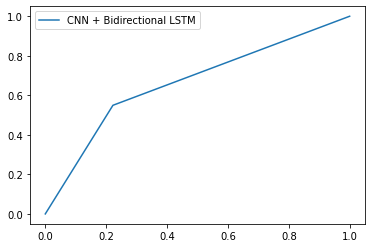

In [17]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='CNN + Bidirectional LSTM')
plt.legend()
plt.show()

#### RCNN

In [18]:
class RCNN():
    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='sigmoid')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 1.2397 - accuracy: 0.5240 - auc_7: 0.5161 - precision_7: 0.5236 - recall_7: 0.7519 - f1_score: 0.6760 - val_loss: 0.9863 - val_accuracy: 0.4981 - val_auc_7: 0.5317 - val_precision_7: 0.4961 - val_recall_7: 0.9845 - val_f1_score: 0.6615 - 2s/epoch - 127ms/step
Epoch 2/25
17/17 - 1s - loss: 0.7417 - accuracy: 0.5681 - auc_7: 0.6119 - precision_7: 0.5584 - recall_7: 0.7368 - f1_score: 0.6760 - val_loss: 0.9200 - val_accuracy: 0.4904 - val_auc_7: 0.5026 - val_precision_7: 0.4921 - val_recall_7: 0.9612 - val_f1_score: 0.6667 - 749ms/epoch - 44ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7562 - accuracy: 0.5797 - auc_7: 0.6224 - precision_7: 0.5983 - recall_7: 0.5376 - f1_score: 0.6777 - val_loss: 0.9020 - val_accuracy: 0.5019 - val_auc_7: 0.5555 - val_precision_7: 0.4980 - val_recall_7: 0.9845 - val_f1_score: 0.6632 - 765ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.7869 - accuracy: 0.5643 - auc_7: 0.6188 - precision_7: 0.5704 - recall_7: 0.5940 - f1_score: 0

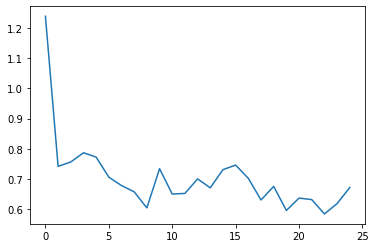

Epoch 1/25
17/17 - 2s - loss: 1.5527 - accuracy: 0.5278 - auc_8: 0.5212 - precision_8: 0.5357 - recall_8: 0.3488 - f1_score: 0.6624 - val_loss: 0.7973 - val_accuracy: 0.6360 - val_auc_8: 0.5148 - val_precision_8: 0.6400 - val_recall_8: 0.7007 - val_f1_score: 0.6851 - 2s/epoch - 117ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8751 - accuracy: 0.5585 - auc_8: 0.5745 - precision_8: 0.5350 - recall_8: 0.8295 - f1_score: 0.6624 - val_loss: 0.7125 - val_accuracy: 0.5249 - val_auc_8: 0.5076 - val_precision_8: 0.5251 - val_recall_8: 0.9927 - val_f1_score: 0.6884 - 845ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7474 - accuracy: 0.5681 - auc_8: 0.6155 - precision_8: 0.5696 - recall_8: 0.5233 - f1_score: 0.6624 - val_loss: 0.6928 - val_accuracy: 0.5249 - val_auc_8: 0.5214 - val_precision_8: 0.5251 - val_recall_8: 0.9927 - val_f1_score: 0.6884 - 763ms/epoch - 45ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6582 - accuracy: 0.5988 - auc_8: 0.6460 - precision_8: 0.5891 - recall_8: 0.6279 - f1_score: 0

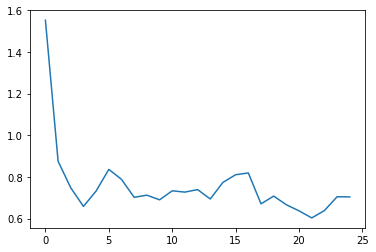

Epoch 1/25
17/17 - 2s - loss: 1.5470 - accuracy: 0.5115 - auc_9: 0.5445 - precision_9: 0.5249 - recall_9: 0.4361 - f1_score: 0.6751 - val_loss: 1.9139 - val_accuracy: 0.5000 - val_auc_9: 0.5490 - val_precision_9: 0.4981 - val_recall_9: 1.0000 - val_f1_score: 0.6632 - 2s/epoch - 109ms/step
Epoch 2/25
17/17 - 1s - loss: 0.8659 - accuracy: 0.5057 - auc_9: 0.5181 - precision_9: 0.5140 - recall_9: 0.5526 - f1_score: 0.6760 - val_loss: 1.6829 - val_accuracy: 0.4885 - val_auc_9: 0.5668 - val_precision_9: 0.1667 - val_recall_9: 0.0078 - val_f1_score: 0.6632 - 780ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 0.7746 - accuracy: 0.5498 - auc_9: 0.5941 - precision_9: 0.5544 - recall_9: 0.5940 - f1_score: 0.6751 - val_loss: 1.0356 - val_accuracy: 0.5885 - val_auc_9: 0.4999 - val_precision_9: 0.5696 - val_recall_9: 0.6977 - val_f1_score: 0.6632 - 692ms/epoch - 41ms/step
Epoch 4/25
17/17 - 1s - loss: 0.6829 - accuracy: 0.5939 - auc_9: 0.6456 - precision_9: 0.6436 - recall_9: 0.4549 - f1_score: 0

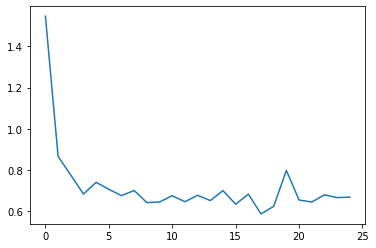

In [19]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [20]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
print('Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Accuracy: 84.03% 
ROC/AUC: 0.54 
Precision: 0.86 
Recall: 0.98 
F1 score: 0.92


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

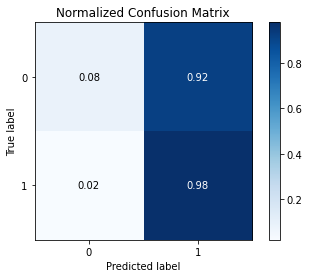

In [21]:
y_pred = np.where(y_pred > 0.5, 1, 0)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

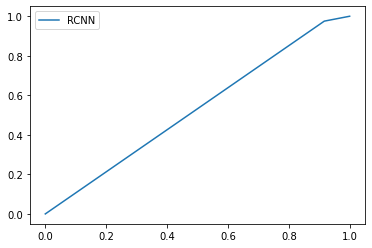

In [22]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='RCNN')
plt.legend()
plt.show()

### Multiclass Classification

#### Dataset

In [23]:
X_train, X_test, y_train, y_test = load_fusioned_dataset()
X = X_train.copy()
y = y_train.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(782, 1, 350, 60) (782, 7)
(238, 1, 350, 60) (238, 7)


In [24]:
n_length, n_features, n_outputs = X_train.shape[2], X_train.shape[-1], y_train.shape[1]

#### CNN + Bidirectional LSTM

In [25]:
class CNNLSTM():
    def __init__(self, n_length, n_features, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=512, kernel_size=3, activation='relu'))(input)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(conv1d)
        flatten = TimeDistributed(Flatten())(maxpool)
        lstm = Bidirectional(LSTM(512, activation='relu'))(flatten)
        dense = Dense(512, activation='relu')(lstm)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 50s - loss: 505971.1875 - accuracy: 0.1689 - auc_11: 0.5165 - precision_11: 0.1689 - recall_11: 0.1689 - f1_score: 0.1142 - val_loss: 296423.8438 - val_accuracy: 0.0881 - val_auc_11: 0.4681 - val_precision_11: 0.0881 - val_recall_11: 0.0881 - val_f1_score: 0.0294 - 50s/epoch - 3s/step
Epoch 2/25
17/17 - 43s - loss: 336559.9375 - accuracy: 0.1555 - auc_11: 0.5074 - precision_11: 0.1555 - recall_11: 0.1555 - f1_score: 0.0728 - val_loss: 300913.4375 - val_accuracy: 0.0192 - val_auc_11: 0.4278 - val_precision_11: 0.0192 - val_recall_11: 0.0192 - val_f1_score: 0.0197 - 43s/epoch - 3s/step
Epoch 3/25
17/17 - 38s - loss: 553832.6250 - accuracy: 0.2054 - auc_11: 0.5380 - precision_11: 0.2054 - recall_11: 0.2054 - f1_score: 0.0858 - val_loss: 385758.9375 - val_accuracy: 0.4981 - val_auc_11: 0.7072 - val_precision_11: 0.4981 - val_recall_11: 0.4981 - val_f1_score: 0.0970 - 38s/epoch - 2s/step
Epoch 4/25
17/17 - 36s - loss: 262390.8438 - accuracy: 0.3455 - auc_11: 0.6191 - prec

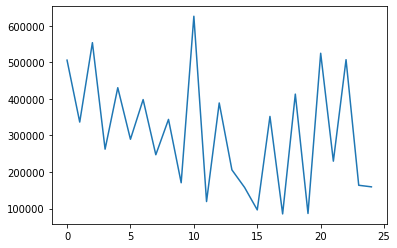

Epoch 1/25
17/17 - 42s - loss: 219458.2344 - accuracy: 0.2476 - auc_12: 0.5628 - precision_12: 0.2476 - recall_12: 0.2476 - f1_score: 0.1386 - val_loss: 244045.1250 - val_accuracy: 0.1149 - val_auc_12: 0.4837 - val_precision_12: 0.1149 - val_recall_12: 0.1149 - val_f1_score: 0.0311 - 42s/epoch - 2s/step
Epoch 2/25
17/17 - 34s - loss: 298072.8125 - accuracy: 0.1612 - auc_12: 0.5107 - precision_12: 0.1612 - recall_12: 0.1612 - f1_score: 0.0919 - val_loss: 177477.9844 - val_accuracy: 0.2069 - val_auc_12: 0.5374 - val_precision_12: 0.2069 - val_recall_12: 0.2069 - val_f1_score: 0.0508 - 34s/epoch - 2s/step
Epoch 3/25
17/17 - 28s - loss: 424292.5625 - accuracy: 0.3129 - auc_12: 0.5981 - precision_12: 0.3129 - recall_12: 0.3129 - f1_score: 0.1340 - val_loss: 179438.5781 - val_accuracy: 0.0881 - val_auc_12: 0.4681 - val_precision_12: 0.0881 - val_recall_12: 0.0881 - val_f1_score: 0.0247 - 28s/epoch - 2s/step
Epoch 4/25
17/17 - 32s - loss: 381212.7188 - accuracy: 0.1843 - auc_12: 0.5281 - prec

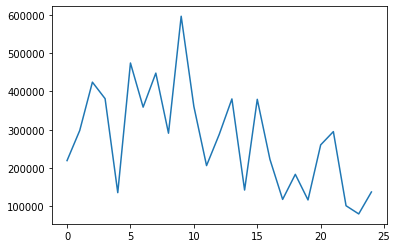

Epoch 1/25
17/17 - 43s - loss: 479724.4062 - accuracy: 0.1801 - auc_13: 0.5235 - precision_13: 0.1801 - recall_13: 0.1801 - f1_score: 0.1158 - val_loss: 116211.1719 - val_accuracy: 0.1385 - val_auc_13: 0.4974 - val_precision_13: 0.1385 - val_recall_13: 0.1385 - val_f1_score: 0.0364 - 43s/epoch - 3s/step
Epoch 2/25
17/17 - 33s - loss: 447413.9688 - accuracy: 0.2165 - auc_13: 0.5428 - precision_13: 0.2165 - recall_13: 0.2165 - f1_score: 0.1412 - val_loss: 65845.4375 - val_accuracy: 0.1077 - val_auc_13: 0.4795 - val_precision_13: 0.1077 - val_recall_13: 0.1077 - val_f1_score: 0.0306 - 33s/epoch - 2s/step
Epoch 3/25
17/17 - 32s - loss: 603541.6250 - accuracy: 0.2203 - auc_13: 0.5456 - precision_13: 0.2203 - recall_13: 0.2203 - f1_score: 0.1010 - val_loss: 25539.2656 - val_accuracy: 0.0962 - val_auc_13: 0.4722 - val_precision_13: 0.0962 - val_recall_13: 0.0962 - val_f1_score: 0.0519 - 32s/epoch - 2s/step
Epoch 4/25
17/17 - 30s - loss: 619172.8125 - accuracy: 0.1973 - auc_13: 0.5331 - precis

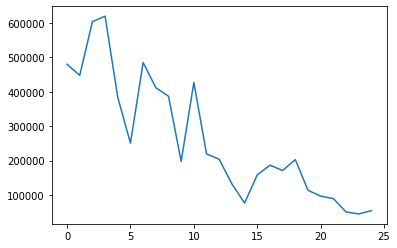

In [29]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = CNNLSTM(n_length, n_features, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs, batch_size, class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [30]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 19.33% 
Balanced Accuracy: 17.77% 
ROC/AUC: 0.53 
Precision: 0.19 
Recall: 0.19 
F1 score: 0.12


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

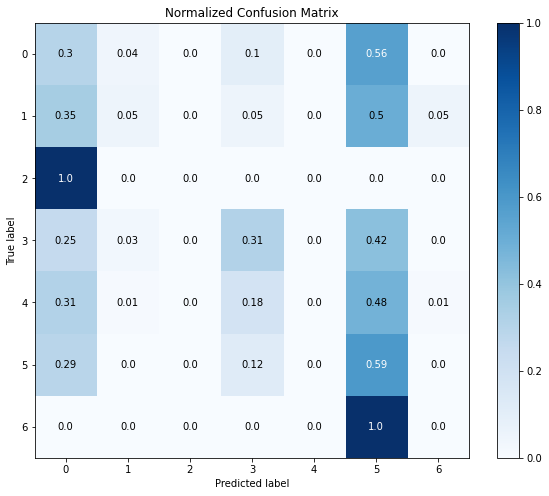

In [31]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

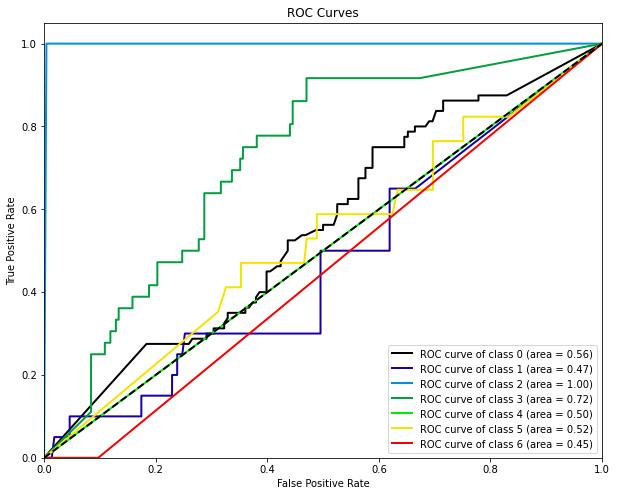

In [32]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

#### RCNN

In [33]:
class RCNN():

    def __init__(self, n_features, n_length, n_outputs):
        input = Input(shape=(1, n_length, n_features))
        conv1d = TimeDistributed(Conv1D(filters=100, kernel_size=3, activation=PReLU(alpha_initializer=Constant(value=0.25))))(input)
        bn = TimeDistributed(BatchNormalization())(conv1d)
        maxpool = TimeDistributed(MaxPooling1D(pool_size=2, strides=2, data_format='channels_first'))(bn)
        flatten = Flatten()(maxpool)
        dense = Dense(100, activation=PReLU(alpha_initializer=Constant(value=0.25)))(flatten)
        output = Dense(units=n_outputs, activation='softmax')(dense)
        model = Model(inputs=input, outputs=output)
        model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, class_weight=class_weight, callbacks=[early_stopping], verbose=2)
        return history

    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results
    
    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

Epoch 1/25
17/17 - 2s - loss: 19.2859 - accuracy: 0.1612 - auc_14: 0.5913 - precision_14: 0.1720 - recall_14: 0.0518 - f1_score: 0.1058 - val_loss: 2.9848 - val_accuracy: 0.2146 - val_auc_14: 0.5711 - val_precision_14: 0.4545 - val_recall_14: 0.0192 - val_f1_score: 0.0744 - 2s/epoch - 140ms/step
Epoch 2/25
17/17 - 1s - loss: 9.9537 - accuracy: 0.1919 - auc_14: 0.6220 - precision_14: 0.2318 - recall_14: 0.0672 - f1_score: 0.1451 - val_loss: 3.0739 - val_accuracy: 0.1992 - val_auc_14: 0.4859 - val_precision_14: 0.3636 - val_recall_14: 0.0153 - val_f1_score: 0.0544 - 775ms/epoch - 46ms/step
Epoch 3/25
17/17 - 1s - loss: 8.6793 - accuracy: 0.1324 - auc_14: 0.5884 - precision_14: 0.1825 - recall_14: 0.0441 - f1_score: 0.1117 - val_loss: 2.6498 - val_accuracy: 0.0805 - val_auc_14: 0.6046 - val_precision_14: 0.2727 - val_recall_14: 0.0115 - val_f1_score: 0.0253 - 788ms/epoch - 46ms/step
Epoch 4/25
17/17 - 1s - loss: 7.5932 - accuracy: 0.2860 - auc_14: 0.7199 - precision_14: 0.4219 - recall_14

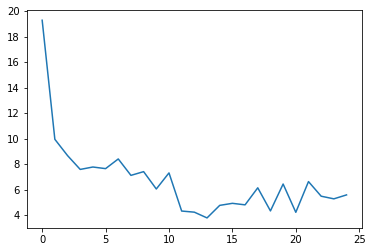

Epoch 1/25
17/17 - 2s - loss: 11.4607 - accuracy: 0.1401 - auc_15: 0.5842 - precision_15: 0.1019 - recall_15: 0.0307 - f1_score: 0.0889 - val_loss: 2.1852 - val_accuracy: 0.2069 - val_auc_15: 0.6898 - val_precision_15: 0.5000 - val_recall_15: 0.0077 - val_f1_score: 0.0596 - 2s/epoch - 144ms/step
Epoch 2/25
17/17 - 1s - loss: 5.6559 - accuracy: 0.3129 - auc_15: 0.6826 - precision_15: 0.2441 - recall_15: 0.0595 - f1_score: 0.1602 - val_loss: 2.7895 - val_accuracy: 0.1149 - val_auc_15: 0.5777 - val_precision_15: 0.2500 - val_recall_15: 0.0038 - val_f1_score: 0.0311 - 857ms/epoch - 50ms/step
Epoch 3/25
17/17 - 1s - loss: 5.2954 - accuracy: 0.1804 - auc_15: 0.6383 - precision_15: 0.3663 - recall_15: 0.0710 - f1_score: 0.1362 - val_loss: 2.4490 - val_accuracy: 0.0881 - val_auc_15: 0.6030 - val_precision_15: 0.2500 - val_recall_15: 0.0038 - val_f1_score: 0.0247 - 990ms/epoch - 58ms/step
Epoch 4/25
17/17 - 1s - loss: 6.2087 - accuracy: 0.1919 - auc_15: 0.6946 - precision_15: 0.3772 - recall_15

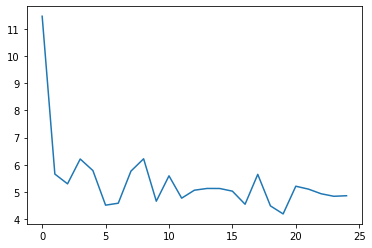

Epoch 1/25
17/17 - 2s - loss: 13.5931 - accuracy: 0.3199 - auc_16: 0.5613 - precision_16: 0.1667 - recall_16: 0.0536 - f1_score: 0.1450 - val_loss: 6.3811 - val_accuracy: 0.4923 - val_auc_16: 0.7529 - val_precision_16: 0.2000 - val_recall_16: 0.0038 - val_f1_score: 0.0945 - 2s/epoch - 121ms/step
Epoch 2/25
17/17 - 1s - loss: 12.0421 - accuracy: 0.3352 - auc_16: 0.6371 - precision_16: 0.2685 - recall_16: 0.0556 - f1_score: 0.1331 - val_loss: 3.3847 - val_accuracy: 0.2038 - val_auc_16: 0.6660 - val_precision_16: 0.4000 - val_recall_16: 0.0077 - val_f1_score: 0.0667 - 735ms/epoch - 43ms/step
Epoch 3/25
17/17 - 1s - loss: 9.3738 - accuracy: 0.1935 - auc_16: 0.5929 - precision_16: 0.2435 - recall_16: 0.0536 - f1_score: 0.1182 - val_loss: 2.7706 - val_accuracy: 0.0038 - val_auc_16: 0.5099 - val_precision_16: 0.2000 - val_recall_16: 0.0038 - val_f1_score: 0.0022 - 730ms/epoch - 43ms/step
Epoch 4/25
17/17 - 1s - loss: 6.3492 - accuracy: 0.0862 - auc_16: 0.5962 - precision_16: 0.3231 - recall_1

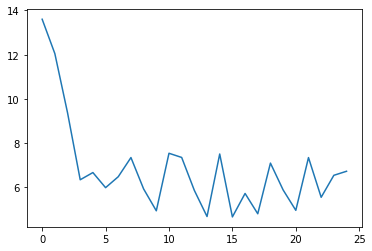

In [34]:
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = RCNN(n_features, n_length, n_outputs)
    history = model.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

##### Prediction on the holdout set

In [35]:
y_pred = model.predict(X_test)
_, acc, auc, precision, recall, f1 = model.evaluate(X_test, y_test)
bal_acc = balanced_accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) 
print('Accuracy: {:.2f}% \nBalanced Accuracy: {:.2f}% \nROC/AUC: {:.2f} \nPrecision: {:.2f} \nRecall: {:.2f} \nF1 score: {:.2f}'.format(acc * 100, bal_acc * 100, auc, precision, recall, f1))

Accuracy: 4.62% 
Balanced Accuracy: 16.23% 
ROC/AUC: 0.62 
Precision: 0.71 
Recall: 0.04 
F1 score: 0.04


<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

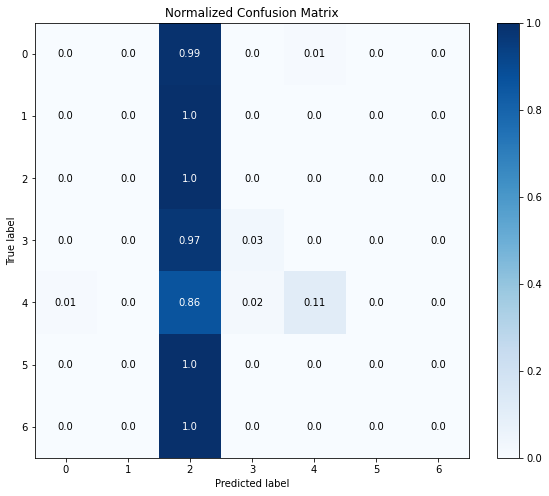

In [36]:
skplt.metrics.plot_confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize=True, figsize=(10,8))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

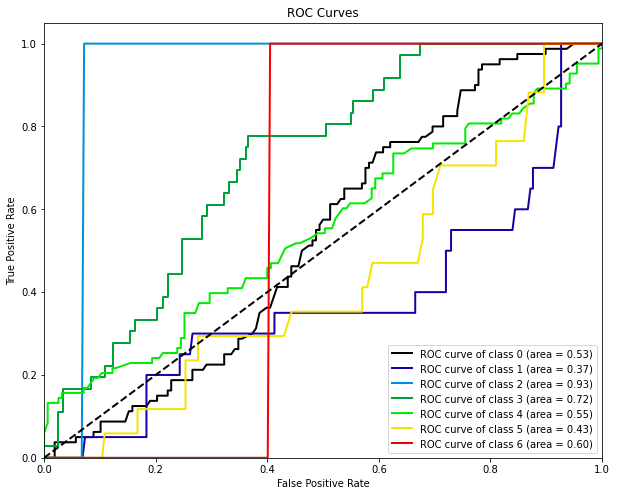

In [37]:
skplt.metrics.plot_roc(y_test.argmax(axis=1), y_pred, plot_micro=False, plot_macro=False, figsize=(10,8))

## 4. Multimodal Late Fusion